In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable

from src.get_nets import PNet, RNet, ONet
from src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from src.first_stage import run_first_stage
from src.visualization_utils import show_bboxes

# Load models

In [97]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

# Set hyperparameters

In [98]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 15.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

# Load an image

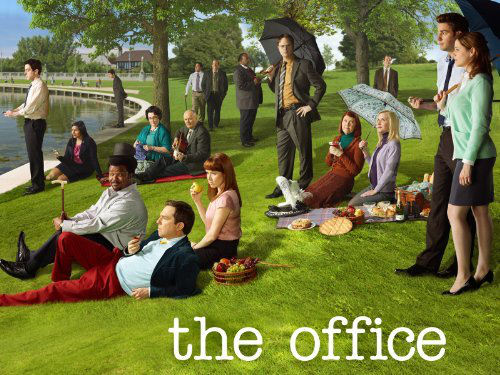

In [99]:
image = Image.open('images/office5.jpg')
image

# build an image pyramid

In [100]:
width, height = image.size
min_length = min(height, width)

min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))

scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04']
number of different scales: 10


# P-Net

In [101]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
    bounding_boxes.append(boxes)

# collect boxes (and offsets, and scores) from different scales
bounding_boxes = [i for i in bounding_boxes if i is not None] #排除bounding_box为None的情况（9,152,9）
bounding_boxes = np.vstack(bounding_boxes) 
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 338


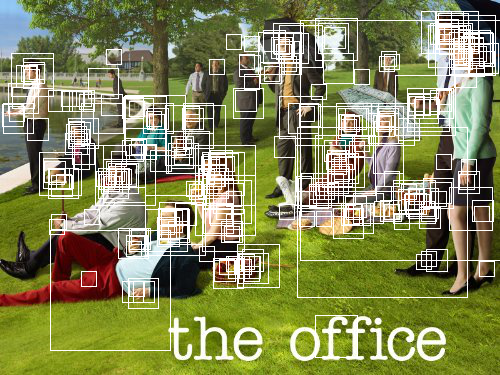

In [102]:
show_bboxes(image, bounding_boxes)

# NMS + calibration

In [103]:
keep = nms(bounding_boxes, nms_thresholds[1])
bounding_boxes = bounding_boxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
# shape [n_boxes, 5]

bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 338


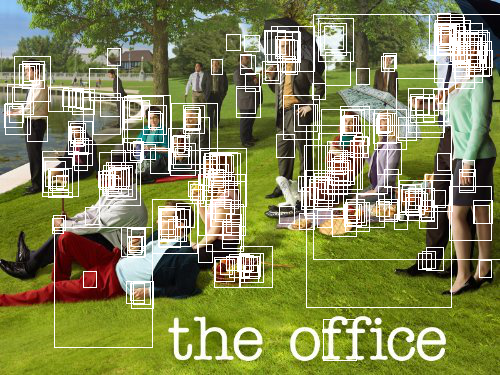

In [82]:
show_bboxes(image, bounding_boxes)

# R-Net

In [128]:
img_boxes = get_image_boxes(bounding_boxes, image, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = rnet(img_boxes)
offsets = output[0].data.numpy()  # shape [n_boxes, 4]
probs = output[1].data.numpy()  # shape [n_boxes, 2]

G:\Entertainment\pycharm\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
G:\Entertainment\others\pynote\python\MTCNN\src\get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [129]:
keep = np.where(probs[:, 1] > thresholds[1])[0]
bounding_boxes = bounding_boxes[keep]#根据得分情况选择合适的box
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))#得分情况的改变
offsets = offsets[keep]  #偏移量的改变

print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 71


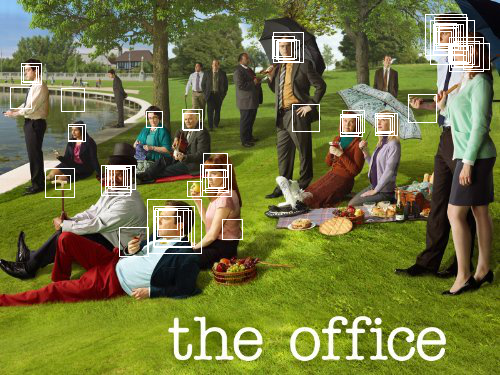

In [130]:
show_bboxes(image, bounding_boxes)

# NMS + calibration

In [131]:
keep = nms(bounding_boxes, nms_thresholds[1])
bounding_boxes = bounding_boxes[keep]
bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 58


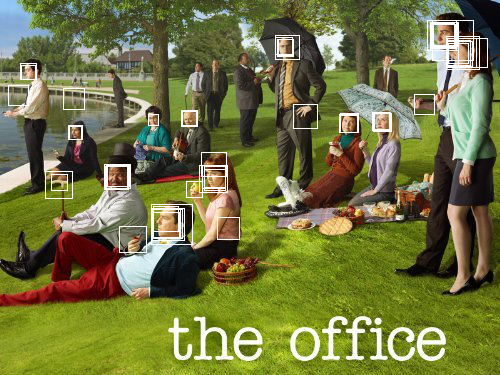

In [132]:
show_bboxes(image, bounding_boxes)

# O-Net

In [16]:
img_boxes = get_image_boxes(bounding_boxes, image, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = onet(img_boxes)
landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
offsets = output[1].data.numpy()  # shape [n_boxes, 4]
probs = output[2].data.numpy()  # shape [n_boxes, 2]

In [17]:
keep = np.where(probs[:, 1] > thresholds[2])[0]
bounding_boxes = bounding_boxes[keep]  #实际坐标
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,)) #得分
offsets = offsets[keep]    #偏移量
landmarks = landmarks[keep]   #guanjiand

# compute landmark points
width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]
    
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 42


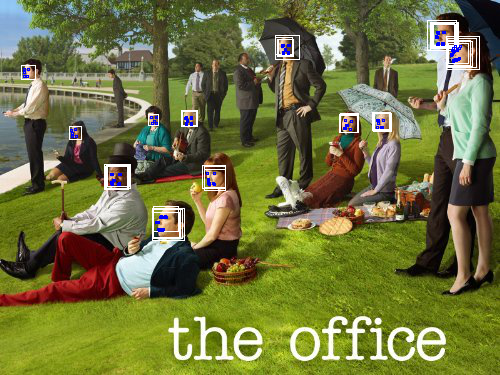

In [18]:
show_bboxes(image, bounding_boxes, landmarks)

# NMS + calibration

In [19]:
bounding_boxes = calibrate_box(bounding_boxes, offsets)
keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
bounding_boxes = bounding_boxes[keep]
landmarks = landmarks[keep]
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 12


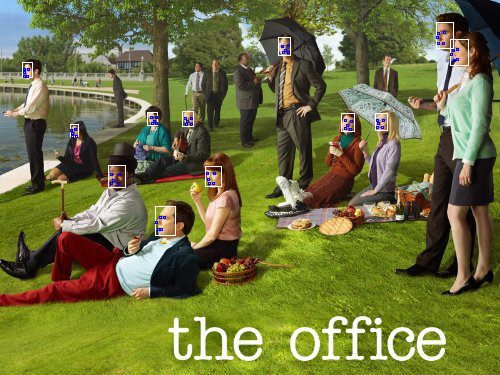

In [20]:
show_bboxes(image, bounding_boxes, landmarks)